## BERT for sequence classification


In [72]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast, \
     DataCollatorWithPadding, pipeline
from datasets import Dataset
import numpy as np
import evaluate

In [2]:
snips_file = open('../data/snips.train.txt', 'rb')

snips_rows = snips_file.readlines()

snips_rows[:20]

[b'listen O\r\n',
 b'to O\r\n',
 b'westbam B-artist\r\n',
 b'alumb O\r\n',
 b'allergic B-album\r\n',
 b'on O\r\n',
 b'google B-service\r\n',
 b'music I-service\r\n',
 b'PlayMusic\r\n',
 b'\r\n',
 b'add O\r\n',
 b'step B-entity_name\r\n',
 b'to I-entity_name\r\n',
 b'me I-entity_name\r\n',
 b'to O\r\n',
 b'the O\r\n',
 b'50 B-playlist\r\n',
 b'cl\xc3\xa1sicos I-playlist\r\n',
 b'playlist O\r\n',
 b'AddToPlaylist\r\n']

In [3]:
# This code segment parses the snips dataset into a more manageable format

utterances = []
tokenized_utterances = []
labels_for_tokens = []
sequence_labels = []

utterance, tokenized_utterance, label_for_utterances = '', [], []
for snip_row in snips_rows:
    if len(snip_row) == 2:  # skip over rows with no data
        continue
    if ' ' not in snip_row.decode():  # we've hit a sequence label
        sequence_labels.append(snip_row.decode().strip())
        utterances.append(utterance.strip())
        tokenized_utterances.append(tokenized_utterance)
        labels_for_tokens.append(label_for_utterances)
        utterance = ''
        tokenized_utterance = []
        label_for_utterances = []
        continue
    token, token_label = snip_row.decode().split(' ')
    token_label = token_label.strip()
    utterance += f'{token} '
    tokenized_utterance.append(token)
    label_for_utterances.append(token_label)
    

In [4]:
len(labels_for_tokens), len(tokenized_utterances), len(utterances), len(sequence_labels)

(13084, 13084, 13084, 13084)

In [5]:
utterances[0], sequence_labels[0]

('listen to westbam alumb allergic on google music', 'PlayMusic')

In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [7]:
unique_sequence_labels = list(set(sequence_labels))
unique_sequence_labels

['SearchScreeningEvent',
 'SearchCreativeWork',
 'PlayMusic',
 'BookRestaurant',
 'GetWeather',
 'AddToPlaylist',
 'RateBook']

In [8]:
sequence_labels = [unique_sequence_labels.index(l) for l in sequence_labels]

print(f'There are {len(unique_sequence_labels)} unique sequence labels')

There are 7 unique sequence labels


In [9]:
from functools import reduce

unique_token_labels = list(set(reduce(lambda x, y: x + y, labels_for_tokens)))
labels_for_tokens = [[unique_token_labels.index(_) for _ in l] for l in labels_for_tokens]

print(f'There are {len(unique_token_labels)} unique token labels')

There are 72 unique token labels


In [10]:
print(tokenized_utterances[0])
print(labels_for_tokens[0])
print([unique_token_labels[l] for l in labels_for_tokens[0]])
print(utterances[0])
print(sequence_labels[0])
print(unique_sequence_labels[sequence_labels[0]])

['listen', 'to', 'westbam', 'alumb', 'allergic', 'on', 'google', 'music']
[25, 25, 15, 25, 1, 25, 4, 42]
['O', 'O', 'B-artist', 'O', 'B-album', 'O', 'B-service', 'I-service']
listen to westbam alumb allergic on google music
2
PlayMusic


In [76]:
Dataset

datasets.arrow_dataset.Dataset

In [11]:
snips_dataset = Dataset.from_dict(
    dict(
        utterance=utterances, 
        label=sequence_labels,
        tokens=tokenized_utterances,
        token_labels=labels_for_tokens
    )
)

snips_dataset = snips_dataset.train_test_split(test_size=0.2)

In [77]:
snips_dataset

DatasetDict({
    train: Dataset({
        features: ['utterance', 'label', 'tokens', 'token_labels'],
        num_rows: 10467
    })
    test: Dataset({
        features: ['utterance', 'label', 'tokens', 'token_labels'],
        num_rows: 2617
    })
})

In [78]:
unique_sequence_labels[6]

'RateBook'

In [12]:
snips_dataset['train'][0]

{'utterance': 'rate this textbook 5 stars',
 'label': 6,
 'tokens': ['rate', 'this', 'textbook', '5', 'stars'],
 'token_labels': [25, 34, 64, 69, 50]}

In [80]:
tokenizer('hi')

{'input_ids': [101, 20844, 102], 'attention_mask': [1, 1, 1]}

In [82]:
tokenizer.decode([101, 2603, 1142, 18977, 126, 2940, 102])

'[CLS] rate this textbook 5 stars [SEP]'

In [13]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return tokenizer(examples["utterance"], truncation=True)

In [14]:
seq_clf_tokenized_snips = snips_dataset.map(preprocess_function, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [15]:
# only input_ids, attention_mask, and label are used. The rest are for show
seq_clf_tokenized_snips['train'][0]

{'utterance': 'rate this textbook 5 stars',
 'label': 6,
 'tokens': ['rate', 'this', 'textbook', '5', 'stars'],
 'token_labels': [25, 34, 64, 69, 50],
 'input_ids': [101, 2603, 1142, 18977, 126, 2940, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [16]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
# Data Collator will pad data so that all examples are the same input length.
#  Attention mask is how we ignore attention scores for padding tokens

In [86]:
sequence_clf_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [87]:
{i: l for i, l in enumerate(unique_sequence_labels)}

{0: 'SearchScreeningEvent',
 1: 'SearchCreativeWork',
 2: 'PlayMusic',
 3: 'BookRestaurant',
 4: 'GetWeather',
 5: 'AddToPlaylist',
 6: 'RateBook'}

In [18]:
sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(unique_sequence_labels),
)

# set an index -> label dictionary
sequence_clf_model.config.id2label = {i: l for i, l in enumerate(unique_sequence_labels)}

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [19]:
sequence_clf_model.config.id2label[0]

'SearchScreeningEvent'

In [73]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):  # custom method to take in logits and calculate accuracy of the eval set
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [21]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # some deep learning parameters that the Trainer is able to take in
    warmup_steps=len(seq_clf_tokenized_snips['train']) // 5,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,  # optional
    data_collator=data_collator
)

In [22]:
# Get initial metrics
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.954935908317566,
 'eval_accuracy': 0.1738632021398548,
 'eval_runtime': 10.1366,
 'eval_samples_per_second': 258.173,
 'eval_steps_per_second': 8.089}

In [23]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656


Epoch,Training Loss,Validation Loss,Accuracy
1,0.438200,0.158161,0.978601
2,0.016900,0.050191,0.987772


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_clf/results/checkpoint-328
Configuration saved in ./snips_clf/results/checkpoint-328/config.json
Model weights saved in ./snips_clf/results/checkpoint-328/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Sa

TrainOutput(global_step=656, training_loss=0.6899719095402738, metrics={'train_runtime': 309.9466, 'train_samples_per_second': 67.541, 'train_steps_per_second': 2.116, 'total_flos': 131497001349432.0, 'train_loss': 0.6899719095402738, 'epoch': 2.0})

In [24]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 0.050191015005111694,
 'eval_accuracy': 0.9877722583110432,
 'eval_runtime': 9.8932,
 'eval_samples_per_second': 264.526,
 'eval_steps_per_second': 8.289,
 'epoch': 2.0}

In [26]:
trainer.save_model()

Saving model checkpoint to ./snips_clf/results
Configuration saved in ./snips_clf/results/config.json
Model weights saved in ./snips_clf/results/pytorch_model.bin


In [88]:
pipeline

<function transformers.pipelines.pipeline(task: str = None, model: Optional = None, config: Union[str, transformers.configuration_utils.PretrainedConfig, NoneType] = None, tokenizer: Union[str, transformers.tokenization_utils.PreTrainedTokenizer, transformers.tokenization_utils_fast.PreTrainedTokenizerFast, NoneType] = None, feature_extractor: Union[str, ForwardRef('SequenceFeatureExtractor'), NoneType] = None, framework: Optional[str] = None, revision: Optional[str] = None, use_fast: bool = True, use_auth_token: Union[str, bool, NoneType] = None, device: Union[int, str, ForwardRef('torch.device'), NoneType] = None, device_map=None, torch_dtype=None, trust_remote_code: Optional[bool] = None, model_kwargs: Dict[str, Any] = None, pipeline_class: Optional[Any] = None, **kwargs) -> transformers.pipelines.base.Pipeline>

In [27]:
# We can now load our fine-tuned from our directory
pipe = pipeline("text-classification", "./snips_clf/results", tokenizer=tokenizer)

pipe('Please add Here We Go by Dispatch to my road trip playlist')


loading configuration file ./snips_clf/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "./snips_clf/results",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "SearchScreeningEvent",
    "1": "SearchCreativeWork",
    "2": "PlayMusic",
    "3": "BookRestaurant",
    "4": "GetWeather",
    "5": "AddToPlaylist",
    "6": "RateBook"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype":

[{'label': 'AddToPlaylist', 'score': 0.9931938052177429}]

In [89]:
frozen_sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(unique_sequence_labels),
)

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 28996
}

loading weights file pytorc

In [90]:
# freezes EVERY parameter in our bert model
# does not freeze our classification layer
for param in frozen_sequence_clf_model.distilbert.parameters():
    param.requires_grad = False

In [91]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # some deep learning parameters that the Trainer is able to take in
    warmup_steps=len(seq_clf_tokenized_snips['train']) // 5,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=frozen_sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [92]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 1.9507232904434204,
 'eval_accuracy': 0.15208253725640045,
 'eval_runtime': 9.8112,
 'eval_samples_per_second': 266.736,
 'eval_steps_per_second': 8.358}

In [93]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656


Epoch,Training Loss,Validation Loss,Accuracy
1,1.955300,1.889053,0.439817
2,1.722200,1.675033,0.818877


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_clf/results/checkpoint-328
Configuration saved in ./snips_clf/results/checkpoint-328/config.json
Model weights saved in ./snips_clf/results/checkpoint-328/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Sa

TrainOutput(global_step=656, training_loss=1.8701613674440034, metrics={'train_runtime': 115.0559, 'train_samples_per_second': 181.946, 'train_steps_per_second': 5.702, 'total_flos': 131497001349432.0, 'train_loss': 1.8701613674440034, 'epoch': 2.0})

In [94]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, utterance, tokens. If token_labels, utterance, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 1.675033450126648,
 'eval_accuracy': 0.8188765762323271,
 'eval_runtime': 9.7586,
 'eval_samples_per_second': 268.174,
 'eval_steps_per_second': 8.403,
 'epoch': 2.0}

## BONUS MATERIAL

## BERT for token classification

In [34]:
from transformers import DataCollatorForTokenClassification, DistilBertForTokenClassification, \
                         DistilBertTokenizerFast, pipeline

In [35]:
# using a cased tokenizer because I think case will matter
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

loading file vocab.txt from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/vocab.txt
loading file tokenizer.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/tokenizer_config.json
loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1

In [36]:
snips_dataset['train'][0]

{'utterance': 'rate this textbook 5 stars',
 'label': 6,
 'tokens': ['rate', 'this', 'textbook', '5', 'stars'],
 'token_labels': [25, 34, 64, 69, 50]}

In [37]:
# The given "token_labels" may not match up with the BERT wordpiece tokenization so
#  this function will map them to the tokenization that BERT uses
#  -100 is a reserved for labels where we do not want to calculate losses so BERT doesn't waste time
#  trying to predict tokens like CLS or SEP

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"token_labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:  # Set the special tokens to -100.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # CLS and SEP are labeled as -100
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [38]:
snips_dataset['train'][0]

{'utterance': 'rate this textbook 5 stars',
 'label': 6,
 'tokens': ['rate', 'this', 'textbook', '5', 'stars'],
 'token_labels': [25, 34, 64, 69, 50]}

In [39]:
# map our dataset from sequence classification to be for token classification
tok_clf_tokenized_snips = snips_dataset.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [40]:
tok_clf_tokenized_snips['train'][0]

{'utterance': 'rate this textbook 5 stars',
 'label': 6,
 'tokens': ['rate', 'this', 'textbook', '5', 'stars'],
 'token_labels': [25, 34, 64, 69, 50],
 'input_ids': [101, 2603, 1142, 18977, 126, 2940, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 25, 34, 64, 69, 50, -100]}

In [41]:
tok_clf_tokenized_snips['train'] = tok_clf_tokenized_snips['train'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips['test'] = tok_clf_tokenized_snips['test'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10467
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2617
    })
})

In [42]:
tok_data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [43]:
tok_clf_model = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-cased', num_labels=len(unique_token_labels)
)

# Set our label dictionary
tok_clf_model.config.id2label = {i: l for i, l in enumerate(unique_token_labels)}

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_

In [44]:
tok_clf_model.config.id2label[0], tok_clf_model.config.id2label[1]

('I-object_name', 'B-album')

In [45]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_tok_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
        
    logging_steps=10,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=tok_clf_model,
    args=training_args,
    train_dataset=tok_clf_tokenized_snips['train'],
    eval_dataset=tok_clf_tokenized_snips['test'],
    data_collator=tok_data_collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [46]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 4.259451866149902,
 'eval_runtime': 10.0657,
 'eval_samples_per_second': 259.993,
 'eval_steps_per_second': 8.146}

In [47]:
trainer.train()

/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656


Epoch,Training Loss,Validation Loss
1,0.189800,0.163389
2,0.101600,0.126216


***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_tok_clf/results/checkpoint-328
Configuration saved in ./snips_tok_clf/results/checkpoint-328/config.json
Model weights saved in ./snips_tok_clf/results/checkpoint-328/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_tok_clf/results/checkpoint-656
Configuration saved in ./snips_tok_clf/results/checkpoint-656/config.json
Model weights saved in ./snips_tok_clf/results/checkpoint-656/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./snips_tok_clf/results/checkpoint-656 (score: 0.126215860247612).


TrainOutput(global_step=656, training_loss=0.38503716059210824, metrics={'train_runtime': 316.4388, 'train_samples_per_second': 66.155, 'train_steps_per_second': 2.073, 'total_flos': 129848569510464.0, 'train_loss': 0.38503716059210824, 'epoch': 2.0})

In [48]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 0.126215860247612,
 'eval_runtime': 10.2133,
 'eval_samples_per_second': 256.235,
 'eval_steps_per_second': 8.029,
 'epoch': 2.0}

In [49]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'entity': 'B-entity_name',
  'score': 0.90607077,
  'index': 3,
  'word': 'Here',
  'start': 11,
  'end': 15},
 {'entity': 'I-entity_name',
  'score': 0.94280726,
  'index': 4,
  'word': 'We',
  'start': 16,
  'end': 18},
 {'entity': 'I-entity_name',
  'score': 0.9463891,
  'index': 5,
  'word': 'Go',
  'start': 19,
  'end': 21},
 {'entity': 'I-entity_name',
  'score': 0.885837,
  'index': 6,
  'word': 'by',
  'start': 22,
  'end': 24},
 {'entity': 'I-entity_name',
  'score': 0.6297767,
  'index': 7,
  'word': 'Di',
  'start': 25,
  'end': 27},
 {'entity': 'I-entity_name',
  'score': 0.5654945,
  'index': 8,
  'word': '##sp',
  'start': 27,
  'end': 29},
 {'entity': 'I-entity_name',
  'score': 0.67038316,
  'index': 9,
  'word': '##atch',
  'start': 29,
  'end': 33},
 {'entity': 'B-playlist_owner',
  'score': 0.9949191,
  'index': 11,
  'word': 'my',
  'start': 37,
  'end': 39},
 {'entity': 'B-playlist',
  'score': 0.9953165,
  'index': 12,
  'word': 'road',
  'start': 40,
  'end': 4

In [50]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
pipe('Rate the doog food 5 out of 5')

[{'entity': 'I-object_name',
  'score': 0.8330297,
  'index': 3,
  'word': 'do',
  'start': 9,
  'end': 11},
 {'entity': 'I-object_name',
  'score': 0.9694697,
  'index': 4,
  'word': '##og',
  'start': 11,
  'end': 13},
 {'entity': 'I-object_name',
  'score': 0.9597257,
  'index': 5,
  'word': 'food',
  'start': 14,
  'end': 18},
 {'entity': 'B-rating_value',
  'score': 0.99711144,
  'index': 6,
  'word': '5',
  'start': 19,
  'end': 20},
 {'entity': 'B-best_rating',
  'score': 0.9376369,
  'index': 9,
  'word': '5',
  'start': 28,
  'end': 29}]

## Question/Answering

In [55]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--ber

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/pytorch_model.bin
All model checkpoint weights were used when initializing BertForQuestionAnswering.

All the weights of BertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForQuestionAnswering for predictions without further training.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/vocab.txt
loading file tokenizer.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/tokenizer_config.json
loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/config.json
Model config BertConfig {
  "_

In [56]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.9924461245536804, 'start': 15, 'end': 25, 'answer': 'California'}

In [57]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord 
              "Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the 
              "Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685 
              "established the western boundary of Middlesex and Somerset Counties and later, the Township 
              "of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the 
              "cornerstone for Nassau Hall in 1754, Princeton began its development as a location for 
              "quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone 
              "edifice was one of the largest public buildings in the colonies and became a model for many other 
              "structures in New Jersey and Pennsylvania."""

squad_pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.3114529848098755,
 'start': 277,
 'end': 293,
 'answer': 'The Keith survey'}

In [58]:
PERSON = 'Sinan Ozdemir'

# Note this is NOT an efficient way to search on google. This is done simply for education purposes
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:512]

squad_pipe(f'Who is {PERSON}?', google_html)

{'score': 0.16757938265800476,
 'start': 273,
 'end': 304,
 'answer': 'Founder + CTO - Stealth Startup'}

In [59]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "What survey led to the founding of Princeton?", princeton,
    return_tensors='pt'
)

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-

In [60]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--bert-large-uncased-whole-word-masking-finetuned-squad/snapshots/242d9dbb66bb5033025196d5678907307f8fb098/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--ber

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.7519, -3.6147, -8.6238, -8.5794, -8.7563, -8.1872, -8.1031, -8.2268,
         -7.5512, -9.8327, -5.7519, -6.2746, -4.7469, -7.9981, -6.5231, -6.2942,
         -6.9675, -8.3130, -7.0369, -8.2833, -6.1628, -8.1123, -5.4992, -5.6526,
         -6.2635, -8.3655, -5.3692, -7.8447, -8.8567, -6.3198, -8.5963, -5.9721,
         -7.6136, -7.3562, -8.2679, -8.3762, -6.8817, -7.8089, -7.5480, -7.4207,
         -7.2773, -8.2750, -7.7374, -7.5004, -7.8319, -7.9563, -7.1041, -5.7036,
         -7.5340, -8.4661, -8.3033, -7.9716, -7.2749, -8.5451, -8.1295, -7.2359,
         -8.6795, -8.9292, -7.6118, -8.6576, -6.9020, -5.7518,  6.3959,  5.9311,
         -1.0083, -4.0455,  1.1958, -4.5241, -2.6724, -4.6225, -3.4796, -5.6253,
         -7.3676, -5.4171, -7.9947, -5.3715, -5.9689, -8.1691, -6.2237, -7.7371,
         -4.7933, -5.0089, -6.9667, -5.7007, -3.2038, -4.9603, -4.6802,  1.7422,
         -7.9737, -6.3608, -5.4654, -7.9431, -7.3093, -7

In [61]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_95632/2438474572.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)


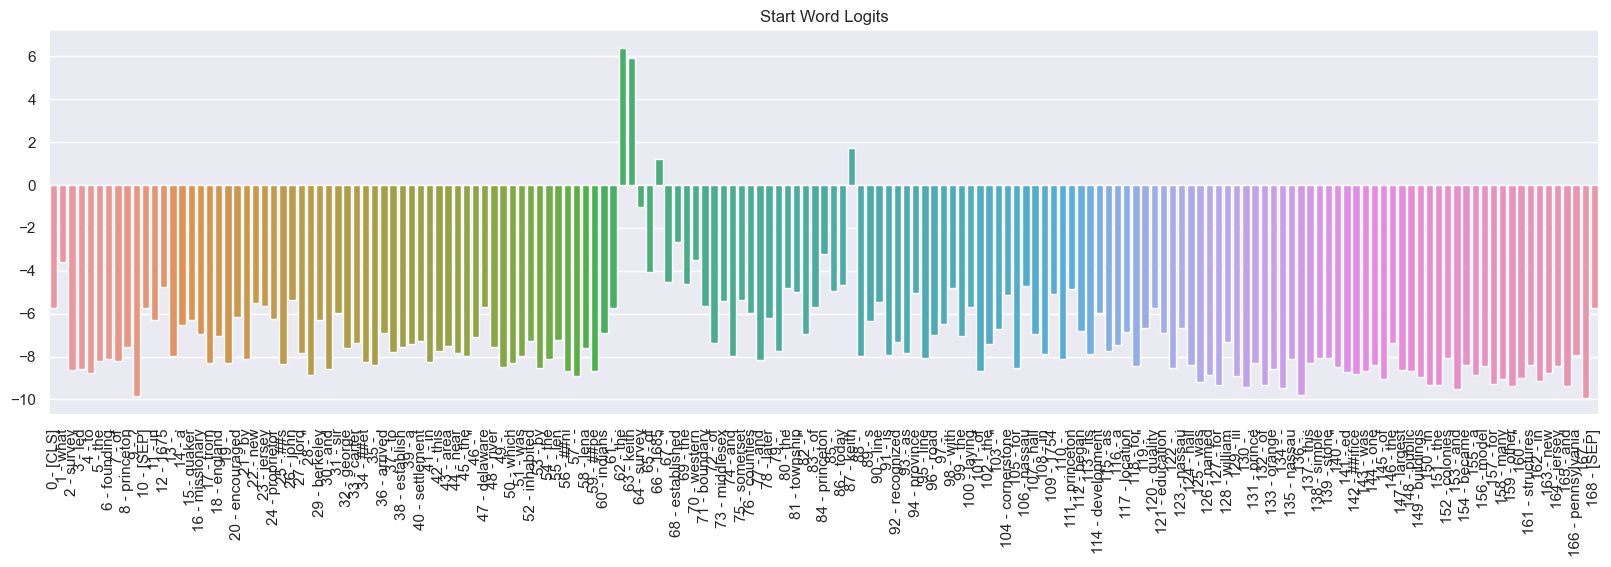

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_95632/2438474572.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)


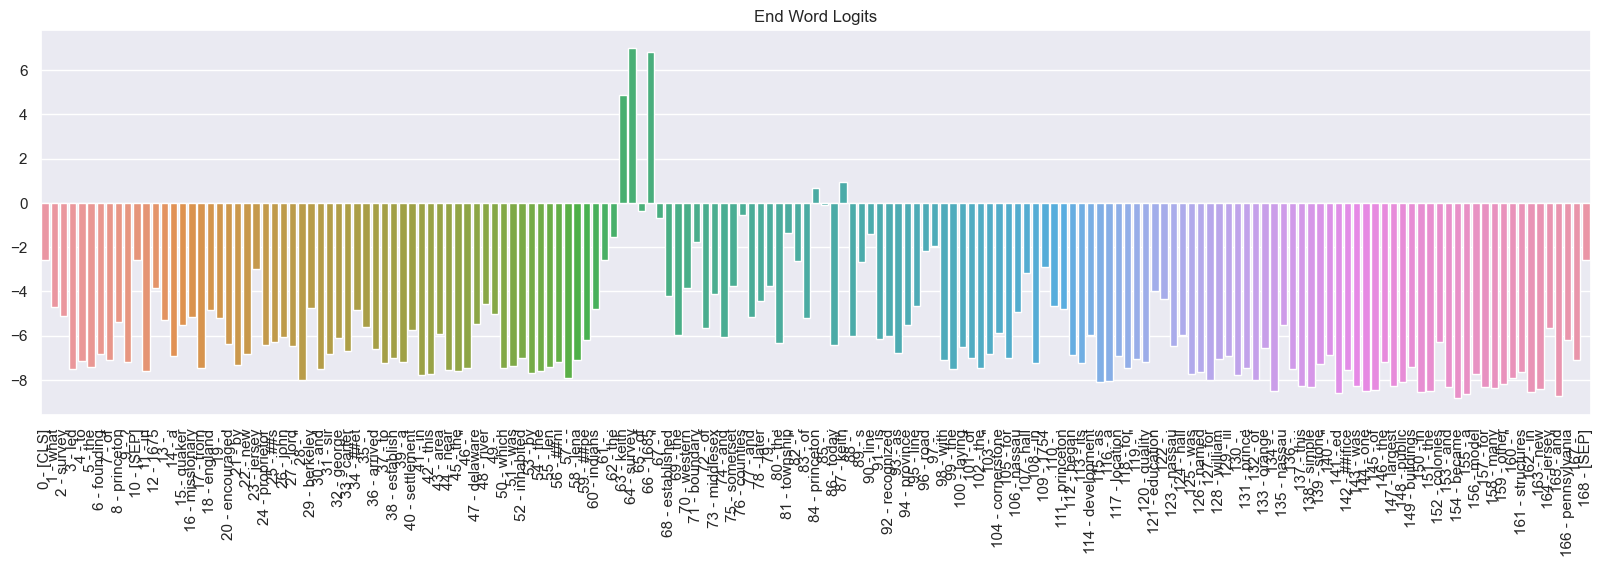

In [62]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)}) 

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()